En este notebook se crea una ultima version limpia de los fuegos a partir del documento provaSHP1999.shp

A partir de la seleccion hecha des de QGIS sobre el documento .gdb que nos porporciona Tecnosylva con informaciones diversas sobre todos los incendios sucedidos en california desde 1850, se crea el documento "fuegosPost1999/provaSHP1999.shp" con información  de todos los fuegos entre Enero de 2000 y Diciembre 2019 

Estos datos son limpiados y transformados a WGS para poder posteriormente buscar los puntos mediante coordenadas  long lat. Los guardamos en el documento de 6278 rows × 3 columns (fecha, tamanyo y perimetro):

'fuegos/fuegosFinal/listaFuegosLIMPIA.shp'




In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np

import datetime
from datetime import date
import timeit

from shapely.geometry import Point,Polygon,MultiPolygon
from shapely.ops import cascaded_union
from pyproj import Proj, transform

import matplotlib.pyplot as plt
#from dateutil.relativedelta import relativedelta

import time

%matplotlib inline

In [2]:

datosFuegos0 = gpd.read_file("fuegosPost1999/provaSHP1999.shp")
datosFuegos0

,OBJECTID,YEAR_,STATE,AGENCY,UNIT_ID,FIRE_NAME,INC_NUM,ALARM_DATE,CONT_DATE,CAUSE,COMMENTS,REPORT_AC,GIS_ACRES,C_METHOD,OBJECTIVE,FIRE_NUM,Shape_Leng,Shape_Area,geometry
0,1.0,2007,CA,CCO,LAC,OCTOBER,00246393,2007/10/21 00:00:00.000,2007/10/23 00:00:00.000,14.0,None,NaN,25.736713,8.0,1.0,00233414,1902.439051,1.041528e+05,"POLYGON ((138036.906 -402646.363, 138086.986 -..."
1,2.0,2007,CA,CCO,LAC,MAGIC,00233077,2007/10/22 00:00:00.000,2007/10/25 00:00:00.000,14.0,None,NaN,2824.877197,8.0,1.0,00233077,20407.965662,1.143187e+07,"POLYGON ((130072.487 -398622.842, 130094.237 -..."
2,3.0,2007,CA,USF,ANF,RANCH,00000166,2007/10/20 00:00:00.000,2007/11/15 00:00:00.000,2.0,None,54716.0,58410.335938,7.0,1.0,00000166,169150.715690,2.363782e+08,"POLYGON ((114013.974 -379231.746, 114190.835 -..."
3,4.0,2007,CA,CCO,LAC,EMMA,00201384,2007/09/11 00:00:00.000,2007/09/11 00:00:00.000,14.0,None,NaN,172.214951,8.0,1.0,00201384,6117.777086,6.969292e+05,"POLYGON ((176902.236 -388673.082, 176907.996 -..."
4,5.0,2007,CA,CCO,LAC,CORRAL,00259483,2007/11/24 00:00:00.000,2007/11/27 00:00:00.000,14.0,None,NaN,4707.997070,8.0,1.0,00259483,22907.182174,1.905259e+07,"POLYGON ((115905.006 -436381.137, 115926.897 -..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6331,21435.0,2019,CA,CCO,LAC,MUREAU,None,2019/10/30 00:00:00.000,2019/10/30 00:00:00.000,NaN,None,NaN,6.297734,NaN,1.0,None,741.886109,2.548602e+04,"POLYGON ((122180.088 -428557.696, 122181.545 -..."
6332,21436.0,2019,CA,LRA,None,OAK,None,2019/10/28 00:00:00.000,2019/10/28 00:00:00.000,14.0,NPS#596 Rapid ROS in light grassy 1yr old fuels,NaN,8.482671,8.0,1.0,None,1004.069271,3.432815e+04,"POLYGON ((120221.043 -428836.863, 120220.166 -..."
6333,21437.0,2019,CA,LRA,LDF,BARHAM,00000845,2019/11/09 00:00:00.000,2019/11/10 00:00:00.000,14.0,LACFD 0845,NaN,64.888229,8.0,1.0,None,3383.890106,2.625933e+05,"POLYGON ((153212.742 -428811.823, 153216.210 -..."
6334,21438.0,2019,CA,NPS,MNP,STAR,00013598,None,None,14.0,None,NaN,66.587181,8.0,1.0,None,3897.065019,2.694688e+05,"POLYGON ((409025.711 -295687.235, 409021.609 -..."


# limpiamos los datos.
 para borrar el minimo valores. 
     - reducimos primero el numero de columnas 
     - seguidamente borramos los nan
     - detectamos y corregimos en lo posible valores obiamente anomalos. 

 se puede mejorar suponiendo la fecha de inicio a partir de la fecha de extincion cuando la primera no esta, aunque esto solo sucede en 6 casos

In [3]:
#len(firePost1999[firePost1999.ALARM_DATE.isna()]) #51
firePost1999= datosFuegos0.drop(['YEAR_','OBJECTID', 'STATE', 'AGENCY', 'CONT_DATE','CAUSE', 'UNIT_ID' ,'FIRE_NAME' ,'INC_NUM','COMMENTS', 'C_METHOD', 'OBJECTIVE', 'REPORT_AC','FIRE_NUM', 'Shape_Leng', 'Shape_Area'], axis=1)
firePost1999=firePost1999.dropna()

firePost1999

,ALARM_DATE,GIS_ACRES,geometry
0,2007/10/21 00:00:00.000,25.736713,"POLYGON ((138036.906 -402646.363, 138086.986 -..."
1,2007/10/22 00:00:00.000,2824.877197,"POLYGON ((130072.487 -398622.842, 130094.237 -..."
2,2007/10/20 00:00:00.000,58410.335938,"POLYGON ((114013.974 -379231.746, 114190.835 -..."
3,2007/09/11 00:00:00.000,172.214951,"POLYGON ((176902.236 -388673.082, 176907.996 -..."
4,2007/11/24 00:00:00.000,4707.997070,"POLYGON ((115905.006 -436381.137, 115926.897 -..."
...,...,...,...
6330,2019/10/21 00:00:00.000,42.282562,"POLYGON ((133621.354 -438205.997, 133621.094 -..."
6331,2019/10/30 00:00:00.000,6.297734,"POLYGON ((122180.088 -428557.696, 122181.545 -..."
6332,2019/10/28 00:00:00.000,8.482671,"POLYGON ((120221.043 -428836.863, 120220.166 -..."
6333,2019/11/09 00:00:00.000,64.888229,"POLYGON ((153212.742 -428811.823, 153216.210 -..."


In [4]:
fuegosOrdenadosXt = firePost1999.sort_values(by=['ALARM_DATE'] , ascending=False,ignore_index=True)
fuegosOrdenadosXt

,ALARM_DATE,GIS_ACRES,geometry
0,2106/09/26 00:00:00.000,930.506470,"POLYGON ((-24253.448 -27481.751, -24309.173 -2..."
1,2019/12/19 00:00:00.000,12.634579,"POLYGON ((-10551.228 -27844.203, -10548.820 -2..."
2,2019/11/25 00:00:00.000,3125.905518,"MULTIPOLYGON (((18960.430 -391658.392, 18956.3..."
3,2019/11/25 00:00:00.000,24.590448,"POLYGON ((-114608.774 92263.611, -114623.297 9..."
4,2019/11/21 00:00:00.000,73.552673,"POLYGON ((-80262.329 225563.780, -80260.657 22..."
...,...,...,...
6274,2000/01/05 00:00:00.000,8.172387,"POLYGON ((-48411.437 -384007.662, -48409.447 -..."
6275,2000/01/04 00:00:00.000,41.443298,"POLYGON ((-9945.240 311.120, -9994.780 278.670..."
6276,2000/01/01 00:00:00.000,4.834736,"POLYGON ((112920.614 -173590.564, 112892.814 -..."
6277,0219/05/29 00:00:00.000,2.296940,"POLYGON ((213452.071 -468768.278, 213452.494 -..."


# vemos que hay fechas imposibles las corregimos manualmente

In [5]:

fuegosOrdenadosXt['ALARM_DATE'] = fuegosOrdenadosXt['ALARM_DATE'].replace(['2106/09/26 00:00:00.000'],'2016/09/26 00:00:00.000')
fuegosOrdenadosXt['ALARM_DATE'] = fuegosOrdenadosXt['ALARM_DATE'].replace(['0219/05/29 00:00:00.000'],'2019/05/29 00:00:00.000')
fuegosOrdenadosXt['ALARM_DATE'] = fuegosOrdenadosXt['ALARM_DATE'].replace(['0208/11/13 00:00:00.000'],'2008/11/13 00:00:00.000')

fuegosOrdenadosXt

,ALARM_DATE,GIS_ACRES,geometry
0,2016/09/26 00:00:00.000,930.506470,"POLYGON ((-24253.448 -27481.751, -24309.173 -2..."
1,2019/12/19 00:00:00.000,12.634579,"POLYGON ((-10551.228 -27844.203, -10548.820 -2..."
2,2019/11/25 00:00:00.000,3125.905518,"MULTIPOLYGON (((18960.430 -391658.392, 18956.3..."
3,2019/11/25 00:00:00.000,24.590448,"POLYGON ((-114608.774 92263.611, -114623.297 9..."
4,2019/11/21 00:00:00.000,73.552673,"POLYGON ((-80262.329 225563.780, -80260.657 22..."
...,...,...,...
6274,2000/01/05 00:00:00.000,8.172387,"POLYGON ((-48411.437 -384007.662, -48409.447 -..."
6275,2000/01/04 00:00:00.000,41.443298,"POLYGON ((-9945.240 311.120, -9994.780 278.670..."
6276,2000/01/01 00:00:00.000,4.834736,"POLYGON ((112920.614 -173590.564, 112892.814 -..."
6277,2019/05/29 00:00:00.000,2.296940,"POLYGON ((213452.071 -468768.278, 213452.494 -..."


In [6]:
# modificamos el tipo de fecha para poder buscar mejor
listaDeFechas=[]

for fuego in range(len(fuegosOrdenadosXt)):
    fecha=datetime.date(int(fuegosOrdenadosXt.ALARM_DATE[fuego][0:4]),int(fuegosOrdenadosXt.ALARM_DATE[fuego][5:7]),int(fuegosOrdenadosXt.ALARM_DATE[fuego][8:10]))
    listaDeFechas.append(fecha)
len(listaDeFechas)

6279

In [7]:
fuegosOrdenadosXt['DATE']=fuegosOrdenadosXt['ALARM_DATE']
fuegosOrdenadosXt['ALARM_DATE']=listaDeFechas
fuegosOrdenadosXt

,ALARM_DATE,GIS_ACRES,geometry,DATE
0,2016-09-26,930.506470,"POLYGON ((-24253.448 -27481.751, -24309.173 -2...",2016/09/26 00:00:00.000
1,2019-12-19,12.634579,"POLYGON ((-10551.228 -27844.203, -10548.820 -2...",2019/12/19 00:00:00.000
2,2019-11-25,3125.905518,"MULTIPOLYGON (((18960.430 -391658.392, 18956.3...",2019/11/25 00:00:00.000
3,2019-11-25,24.590448,"POLYGON ((-114608.774 92263.611, -114623.297 9...",2019/11/25 00:00:00.000
4,2019-11-21,73.552673,"POLYGON ((-80262.329 225563.780, -80260.657 22...",2019/11/21 00:00:00.000
...,...,...,...,...
6274,2000-01-05,8.172387,"POLYGON ((-48411.437 -384007.662, -48409.447 -...",2000/01/05 00:00:00.000
6275,2000-01-04,41.443298,"POLYGON ((-9945.240 311.120, -9994.780 278.670...",2000/01/04 00:00:00.000
6276,2000-01-01,4.834736,"POLYGON ((112920.614 -173590.564, 112892.814 -...",2000/01/01 00:00:00.000
6277,2019-05-29,2.296940,"POLYGON ((213452.071 -468768.278, 213452.494 -...",2019/05/29 00:00:00.000


In [8]:
del fuegosOrdenadosXt['DATE']
fuegosOrdenados = fuegosOrdenadosXt.sort_values(by=['ALARM_DATE'] , ascending=True,ignore_index=True)
fuegosOrdenados

,ALARM_DATE,GIS_ACRES,geometry
0,2000-01-01,4.834736,"POLYGON ((112920.614 -173590.564, 112892.814 -..."
1,2000-01-04,41.443298,"POLYGON ((-9945.240 311.120, -9994.780 278.670..."
2,2000-01-05,8.172387,"POLYGON ((-48411.437 -384007.662, -48409.447 -..."
3,2000-02-25,171.886719,"POLYGON ((154724.105 -392690.642, 154727.775 -..."
4,2000-03-25,1358.237549,"MULTIPOLYGON (((-246428.582 161994.989, -24642..."
...,...,...,...
6274,2019-11-19,7.903546,"POLYGON ((-12860.145 8874.868, -12865.393 8879..."
6275,2019-11-21,73.552673,"POLYGON ((-80262.329 225563.780, -80260.657 22..."
6276,2019-11-25,24.590448,"POLYGON ((-114608.774 92263.611, -114623.297 9..."
6277,2019-11-25,3125.905518,"MULTIPOLYGON (((18960.430 -391658.392, 18956.3..."


# he detectado algun proglema que no entiendo en el fuego de la posicion 4284 y lo borro. DE hecho sale en rojo en lugar de en verde pero tampoco se pq

In [9]:
fuegosOrdenados['GIS_ACRES'][4284]

21.705001831054688

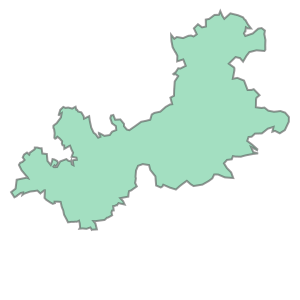

In [11]:
fuegosOrdenados['geometry'][4283]

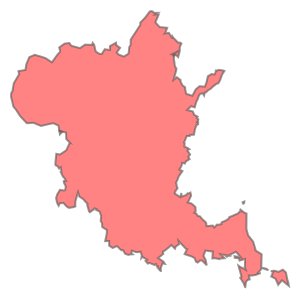

In [10]:
fuegosOrdenados['geometry'][4284]

In [12]:

fuegosOrdenados2= fuegosOrdenados.drop(fuegosOrdenados.index[4284])
fuegosOrdenados2

,ALARM_DATE,GIS_ACRES,geometry
0,2000-01-01,4.834736,"POLYGON ((112920.614 -173590.564, 112892.814 -..."
1,2000-01-04,41.443298,"POLYGON ((-9945.240 311.120, -9994.780 278.670..."
2,2000-01-05,8.172387,"POLYGON ((-48411.437 -384007.662, -48409.447 -..."
3,2000-02-25,171.886719,"POLYGON ((154724.105 -392690.642, 154727.775 -..."
4,2000-03-25,1358.237549,"MULTIPOLYGON (((-246428.582 161994.989, -24642..."
...,...,...,...
6274,2019-11-19,7.903546,"POLYGON ((-12860.145 8874.868, -12865.393 8879..."
6275,2019-11-21,73.552673,"POLYGON ((-80262.329 225563.780, -80260.657 22..."
6276,2019-11-25,24.590448,"POLYGON ((-114608.774 92263.611, -114623.297 9..."
6277,2019-11-25,3125.905518,"MULTIPOLYGON (((18960.430 -391658.392, 18956.3..."


In [13]:
fuegosOrdenados2.crs

{'proj': 'aea',
 'lat_1': 34,
 'lat_2': 40.5,
 'lat_0': 0,
 'lon_0': -120,
 'x_0': 0,
 'y_0': -4000000,
 'datum': 'NAD83',
 'units': 'm',
 'no_defs': True}

# los convertimos a 4326

In [14]:
fuegoS_4326  = fuegosOrdenados2.to_crs({'init': 'epsg:4326'})
fuegoS_4326

,ALARM_DATE,GIS_ACRES,geometry
0,2000-01-01,4.834736,"POLYGON ((-118.73853 36.44793, -118.73883 36.4..."
1,2000-01-04,41.443298,"POLYGON ((-120.11343 38.01911, -120.11400 38.0..."
2,2000-01-05,8.172387,"POLYGON ((-120.52776 34.55901, -120.52774 34.5..."
3,2000-02-25,171.886719,"POLYGON ((-118.31511 34.46959, -118.31507 34.4..."
4,2000-03-25,1358.237549,"MULTIPOLYGON (((-122.86557 39.44029, -122.8654..."
...,...,...,...
6274,2019-11-19,7.903546,"POLYGON ((-120.14683 38.09611, -120.14689 38.0..."
6275,2019-11-21,73.552673,"POLYGON ((-120.94091 40.04237, -120.94090 40.0..."
6276,2019-11-25,24.590448,"POLYGON ((-121.32173 38.83918, -121.32190 38.8..."
6277,2019-11-25,3125.905518,"MULTIPOLYGON (((-119.79348 34.49110, -119.7935..."


# GUARDAMOS LA LSITA DE FUEGOS DEFININTIVA COMO listaFuegosLIMPIA.shp

In [44]:
GUARDADOS
#para poderlo guardar en shapefile primero tenemos que convertir la fecha en string
fuegoS_4326["ALARM_DATE"] = fuegoS_4326["ALARM_DATE"].astype(str) 
direccion='fuegos/fuegosFinal/listaFuegosLIMPIA.shp' #to shapefile
fuegoS_4326.to_file(direccion)

In [15]:
#una vez guardado comprobamos que funciona correctamente
direccion='fuegos/fuegosFinal/listaFuegosLIMPIA.shp'
dfTstr= gpd.read_file(direccion)

#para recuperar los el dataframe fuegoS_4326 con las fechas comparables
# convertir los str en fechas
dfTstr["ALARM_DATE"]= pd.to_datetime(dfTstr["ALARM_DATE"])

dfTstr

,ALARM_DATE,GIS_ACRES,geometry
0,2000-01-01,4.834736,"POLYGON ((-118.73853 36.44793, -118.73883 36.4..."
1,2000-01-04,41.443298,"POLYGON ((-120.11343 38.01911, -120.11400 38.0..."
2,2000-01-05,8.172387,"POLYGON ((-120.52776 34.55901, -120.52774 34.5..."
3,2000-02-25,171.886719,"POLYGON ((-118.31511 34.46959, -118.31507 34.4..."
4,2000-03-25,1358.237549,"MULTIPOLYGON (((-122.86557 39.44029, -122.8654..."
...,...,...,...
6273,2019-11-19,7.903546,"POLYGON ((-120.14683 38.09611, -120.14689 38.0..."
6274,2019-11-21,73.552673,"POLYGON ((-120.94091 40.04237, -120.94090 40.0..."
6275,2019-11-25,24.590448,"POLYGON ((-121.32173 38.83918, -121.32190 38.8..."
6276,2019-11-25,3125.905518,"MULTIPOLYGON (((-119.79348 34.49110, -119.7935..."


True

# creamos un shapefile con todos los fuegos de cada anyo por anyo

In [261]:
anyos = list(range(2000,2020))

year=[anyos[0],anyos[0]]
puntDf = pd.DataFrame(year,columns = ['year'])
punGDF = gpd.GeoDataFrame(puntDf, geometry=gpd.GeoSeries(poliPorAnyos[0]))
punGDF.crs={'init': 'epsg:4326'}
punGDF.drop(punGDF.index[1],0,inplace=True)

for x in range(len(anyos)):
    
    anyo=(fuegoS_4326[(fuegoS_4326['ALARM_DATE'] < time_argument2)&(fuegoS_4326['ALARM_DATE'] > time_argument1)])

    time_argument1 = datetime.date(anyos[x], 1, 1)
    time_argument2 = datetime.date(anyos[x]+1, 1, 1)
    
    #print(time_argument1,time_argument2)
    year=[anyos[x],anyos[x]]
    puntDf = pd.DataFrame(year,columns = ['year'])

    punGDF2 = gpd.GeoDataFrame(puntDf, geometry=gpd.GeoSeries(gpd.GeoSeries(cascaded_union(anyo['geometry']))))
    punGDF2.crs={'init': 'epsg:4326'}
    punGDF2.drop(punGDF2.index[1],0,inplace=True)
    punGDF2.head()
    
    punGDF = punGDF.append(punGDF2)
    
punGDF = punGDF[1:]
punGDF=punGDF.reset_index()
punGDF=punGDF.drop(['index'], axis=1)

punGDF

,year,geometry
0,2000,"MULTIPOLYGON (((-116.77621 32.56414, -116.7759..."
1,2001,"MULTIPOLYGON (((-116.67393 32.62110, -116.6735..."
2,2002,"MULTIPOLYGON (((-116.58121 32.61224, -116.5811..."
3,2003,"MULTIPOLYGON (((-116.53615 32.58709, -116.5362..."
4,2004,"MULTIPOLYGON (((-123.62063 39.14653, -123.6206..."
5,2005,"MULTIPOLYGON (((-116.88373 32.55503, -116.8840..."
6,2006,"MULTIPOLYGON (((-116.92656 32.55172, -116.9265..."
7,2007,"MULTIPOLYGON (((-116.86819 32.56156, -116.8682..."
8,2008,"MULTIPOLYGON (((-116.09287 32.61946, -116.0931..."
9,2009,"MULTIPOLYGON (((-116.81815 32.57059, -116.8178..."


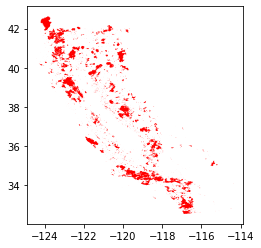

In [192]:
punGDF.plot(color = 'red')
plt.show()

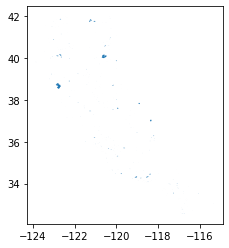

In [198]:
punGDF[punGDF['year']==2000]['geometry'].plot()

In [199]:
# punGDF.to_file("fuegos/fuegosXanyo.shp")

# SEGUIMOS A PARTIR DE AQUI

# 1. CREAMOS UN FONDO COMUN

In [2]:
californiaMap3857 = gpd.read_file("mapasCAlifornia/mapaCalifornia3857/mapaCalifornia.shp")
californiaMap4326  = californiaMap3857.to_crs({'init': 'epsg:4326'})

boundary=gpd.read_file("poligonoMeteo/nc_shrinkboundary.shp")
boundary.crs



{'init': 'epsg:4326'}

In [3]:

zonasPosibles = gpd.overlay(californiaMap4326,boundary, how='intersection')
keep=["NAME","geometry"]
zonasPosibles = zonasPosibles[keep]
zonasPosibles

,NAME,geometry
0,California,"MULTIPOLYGON (((-124.13657 41.46446, -124.1379..."


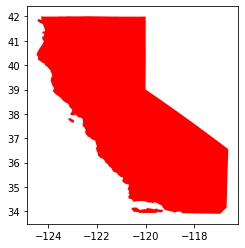

In [4]:
zonasPosibles.plot(color = 'red')
plt.show()

In [5]:
#zonasPosibles.to_file("fuegos/fuegosOrdenadosBASE.shp")

In [6]:
# 2. CREAMOS UNO SHP POR ANYO

In [5]:
fuegosXanyo=gpd.read_file("fuegos/fuegosXanyo.shp")
fuegosXanyo.crs

{'init': 'epsg:4326'}

In [6]:
fuegosXanyo

,year,geometry
0,2000,"MULTIPOLYGON (((-116.77621 32.56414, -116.7759..."
1,2001,"MULTIPOLYGON (((-116.67393 32.62110, -116.6735..."
2,2002,"MULTIPOLYGON (((-116.58121 32.61224, -116.5811..."
3,2003,"MULTIPOLYGON (((-116.53615 32.58709, -116.5362..."
4,2004,"MULTIPOLYGON (((-123.62063 39.14653, -123.6206..."
5,2005,"MULTIPOLYGON (((-116.88373 32.55503, -116.8840..."
6,2006,"MULTIPOLYGON (((-116.92656 32.55172, -116.9265..."
7,2007,"MULTIPOLYGON (((-116.86819 32.56156, -116.8682..."
8,2008,"MULTIPOLYGON (((-116.09287 32.61946, -116.0931..."
9,2009,"MULTIPOLYGON (((-116.81815 32.57059, -116.8178..."


# 3A. GUARDAMOS LOS SHP de AREAS Sin fuego del area de estudio con datos POR ANYO


In [328]:
guardados en la carpeta los19fuegosXanyo
#shapeXanyo=[]

for i in range(20):
    globals()['fuegos' + str(2000+i)] = fuegosXanyo[fuegosXanyo['year']==(2000+i)]
#Esto ha creado und df individual para cada anyo con el nombre: fuegos2000, fuegos2001, etc

    #esto recoge cada uno de los df
    anyoX=globals()['fuegos' + str(2000+i)]
    
    #la combinacion de los df y el mapa recortado de califorrnia da esto
    globals()['sinFuego'+ str(2000+i)] = gpd.overlay(zonasPosibles,anyoX, how='difference')
    
    keep=["geometry"]
    zonasXanyoF = globals()['sinFuego'+ str(2000+i)][keep]
    zonasXanyoF['year']=2000+i
    #shapeXanyo.append(zonasXanyoF)
    
    direccion='fuegos/los19fuegosXanyo/sinFuegos' + str(2000+i)+ '.shp'                                                  
    zonasXanyoF.to_file(direccion)
    
#shapeXanyo


# 3B. GUARDAMOS LOS SHP POR ANYO acumulado!

                                            geometry
0  MULTIPOLYGON (((-115.33583 33.05028, -115.3358...


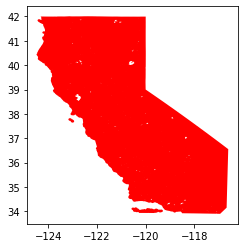

                                            geometry
0  MULTIPOLYGON (((-117.74203 33.77425, -117.7420...
1  MULTIPOLYGON (((-116.33643 32.65540, -116.3383...
2  MULTIPOLYGON (((-115.33583 33.05028, -115.3358...


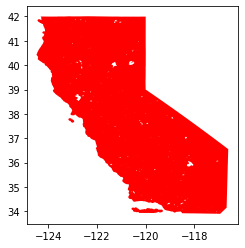

                                            geometry
0  MULTIPOLYGON (((-120.23523 37.72833, -120.2356...
1  MULTIPOLYGON (((-116.82451 32.77347, -116.8245...
2  MULTIPOLYGON (((-116.58121 32.61224, -116.5811...
3  MULTIPOLYGON (((-117.74203 33.77425, -117.7420...
4  MULTIPOLYGON (((-116.33643 32.65540, -116.3383...
5  MULTIPOLYGON (((-115.33583 33.05028, -115.3358...


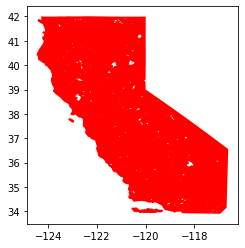

                                            geometry
0  MULTIPOLYGON (((-117.47319 34.31221, -117.4729...
1  MULTIPOLYGON (((-117.81333 34.14385, -117.8133...
2  MULTIPOLYGON (((-118.30571 36.22952, -118.3056...
3  MULTIPOLYGON (((-116.22911 35.84705, -116.2279...
4  MULTIPOLYGON (((-120.23523 37.72833, -120.2356...
5  MULTIPOLYGON (((-116.82451 32.77347, -116.8245...
6  MULTIPOLYGON (((-116.58121 32.61224, -116.5811...
7  MULTIPOLYGON (((-117.74203 33.77425, -117.7420...
8  MULTIPOLYGON (((-116.33643 32.65540, -116.3383...
9  MULTIPOLYGON (((-115.33583 33.05028, -115.3358...


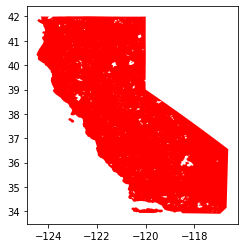

                                             geometry
0   MULTIPOLYGON (((-116.66361 32.83563, -116.6637...
1   MULTIPOLYGON (((-116.48417 32.92932, -116.4837...
2   MULTIPOLYGON (((-117.03441 32.92773, -117.0339...
3   MULTIPOLYGON (((-116.57186 32.91490, -116.5719...
4   MULTIPOLYGON (((-116.14428 32.61672, -116.1445...
5   MULTIPOLYGON (((-117.47319 34.31221, -117.4729...
6   MULTIPOLYGON (((-117.81333 34.14385, -117.8133...
7   MULTIPOLYGON (((-118.30571 36.22952, -118.3056...
8   MULTIPOLYGON (((-116.22911 35.84705, -116.2279...
9   MULTIPOLYGON (((-120.23523 37.72833, -120.2356...
10  MULTIPOLYGON (((-116.82451 32.77347, -116.8245...
11  MULTIPOLYGON (((-116.58121 32.61224, -116.5811...
12  MULTIPOLYGON (((-117.74203 33.77425, -117.7420...
13  MULTIPOLYGON (((-116.33643 32.65540, -116.3383...
14  MULTIPOLYGON (((-115.33583 33.05028, -115.3358...


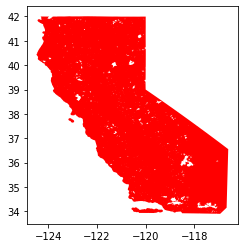

                                             geometry
0   MULTIPOLYGON (((-116.89459 33.59667, -116.8946...
1   POLYGON ((-122.26573 38.89330, -122.26434 38.8...
2   MULTIPOLYGON (((-116.52441 32.97819, -116.5239...
3   MULTIPOLYGON (((-116.52490 32.97835, -116.5250...
4   MULTIPOLYGON (((-117.00811 33.46112, -117.0081...
5   MULTIPOLYGON (((-116.66392 33.21420, -116.6638...
6   POLYGON ((-120.18857 37.62031, -120.18855 37.6...
7   POLYGON ((-116.87583 32.55557, -116.87585 32.5...
8   POLYGON ((-116.52442 32.97819, -116.52441 32.9...
9   MULTIPOLYGON (((-114.98068 35.11480, -114.9806...
10  MULTIPOLYGON (((-116.66361 32.83563, -116.6637...
11  MULTIPOLYGON (((-116.48417 32.92932, -116.4837...
12  MULTIPOLYGON (((-117.03441 32.92773, -117.0339...
13  MULTIPOLYGON (((-116.57186 32.91490, -116.5719...
14  MULTIPOLYGON (((-116.14428 32.61672, -116.1445...
15  MULTIPOLYGON (((-117.47319 34.31221, -117.4729...
16  MULTIPOLYGON (((-117.81333 34.14385, -117.8133...
17  MULTIPOLYGON (((-118.305

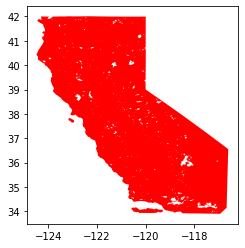

                                             geometry
0   POLYGON ((-120.23872 37.73021, -120.23872 37.7...
1   MULTIPOLYGON (((-116.84582 33.86462, -116.8457...
2   MULTIPOLYGON (((-116.59244 33.14695, -116.5917...
3   MULTIPOLYGON (((-116.60939 33.13412, -116.6094...
4   MULTIPOLYGON (((-117.03243 33.40101, -117.0322...
5   MULTIPOLYGON (((-116.73774 32.57154, -116.7376...
6   MULTIPOLYGON (((-117.05281 34.07753, -117.0529...
7   POLYGON ((-120.83111 36.92081, -120.83065 36.9...
8   MULTIPOLYGON (((-115.25558 35.06619, -115.2555...
9   MULTIPOLYGON (((-116.89459 33.59667, -116.8946...
10  POLYGON ((-122.26573 38.89330, -122.26434 38.8...
11  MULTIPOLYGON (((-116.52441 32.97819, -116.5239...
12  MULTIPOLYGON (((-116.52490 32.97835, -116.5250...
13  MULTIPOLYGON (((-117.00811 33.46112, -117.0081...
14  MULTIPOLYGON (((-116.66392 33.21420, -116.6638...
15  POLYGON ((-120.18857 37.62031, -120.18855 37.6...
16  POLYGON ((-116.87583 32.55557, -116.87585 32.5...
17  POLYGON ((-116.52442 32.

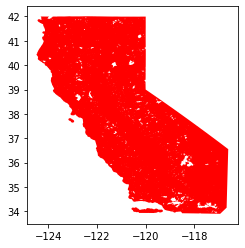

                                             geometry
0   MULTIPOLYGON (((-116.83893 33.86465, -116.8386...
1   MULTIPOLYGON (((-116.55337 32.70778, -116.5532...
2   POLYGON ((-120.18830 37.62033, -120.18830 37.6...
3   MULTIPOLYGON (((-116.80906 32.65355, -116.8090...
4   MULTIPOLYGON (((-121.52360 37.70062, -121.5236...
5   MULTIPOLYGON (((-118.89857 36.06541, -118.8983...
6   POLYGON ((-118.87342 34.30755, -118.87366 34.3...
7   MULTIPOLYGON (((-118.18296 36.16243, -118.1830...
8   POLYGON ((-120.18855 37.62075, -120.18866 37.6...
9   POLYGON ((-122.27088 38.90995, -122.27093 38.9...
10  MULTIPOLYGON (((-116.86676 32.55818, -116.8668...
11  MULTIPOLYGON (((-115.50595 35.01109, -115.5069...
12  MULTIPOLYGON (((-116.66744 33.99665, -116.6676...
13  POLYGON ((-120.23629 37.71997, -120.23581 37.7...
14  POLYGON ((-120.18807 37.61957, -120.18823 37.6...
15  POLYGON ((-116.87247 32.55713, -116.87252 32.5...
16  MULTIPOLYGON (((-116.84582 33.86462, -116.8457...
17  POLYGON ((-116.87320 32.

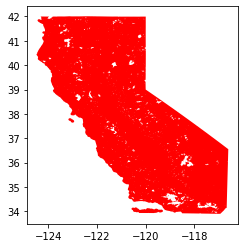

                                             geometry
0   MULTIPOLYGON (((-120.59082 40.15162, -120.5907...
1   MULTIPOLYGON (((-116.57845 32.60993, -116.5795...
2   MULTIPOLYGON (((-116.80906 32.65355, -116.8090...
3   MULTIPOLYGON (((-116.58387 33.09102, -116.5829...
4   MULTIPOLYGON (((-116.65867 32.96395, -116.6585...
..                                                ...
65  MULTIPOLYGON (((-116.82451 32.77347, -116.8245...
66  MULTIPOLYGON (((-116.57845 32.60993, -116.5784...
67  MULTIPOLYGON (((-117.74203 33.77425, -117.7420...
68  MULTIPOLYGON (((-116.33643 32.65540, -116.3383...
69  MULTIPOLYGON (((-115.33583 33.05028, -115.3358...

[70 rows x 1 columns]


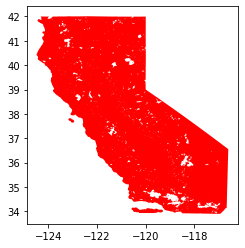

                                             geometry
0   MULTIPOLYGON (((-120.25799 37.77028, -120.2578...
1   POLYGON ((-117.11815 34.17392, -117.11863 34.1...
2   MULTIPOLYGON (((-117.44903 34.26937, -117.4490...
3   MULTIPOLYGON (((-116.81815 32.57059, -116.8178...
4   MULTIPOLYGON (((-117.83930 33.91305, -117.8394...
..                                                ...
85  MULTIPOLYGON (((-116.82451 32.77347, -116.8245...
86  MULTIPOLYGON (((-116.57845 32.60993, -116.5784...
87  MULTIPOLYGON (((-117.74203 33.77425, -117.7420...
88  MULTIPOLYGON (((-116.33643 32.65540, -116.3383...
89  MULTIPOLYGON (((-115.33583 33.05028, -115.3358...

[90 rows x 1 columns]


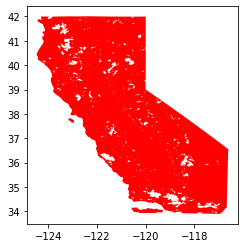

                                              geometry
0    POLYGON ((-118.69816 34.57636, -118.69816 34.5...
1    POLYGON ((-118.97321 34.35086, -118.97287 34.3...
2    POLYGON ((-118.72206 36.15800, -118.72206 36.1...
3    POLYGON ((-118.69810 34.57551, -118.69814 34.5...
4    MULTIPOLYGON (((-122.29849 38.91729, -122.2985...
..                                                 ...
106  MULTIPOLYGON (((-116.82451 32.77347, -116.8245...
107  MULTIPOLYGON (((-116.57845 32.60993, -116.5784...
108  MULTIPOLYGON (((-117.74203 33.77425, -117.7420...
109  MULTIPOLYGON (((-116.33643 32.65540, -116.3383...
110  MULTIPOLYGON (((-115.33583 33.05028, -115.3358...

[111 rows x 1 columns]


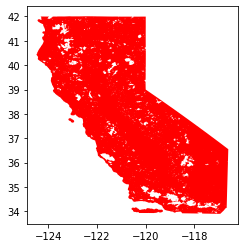

                                              geometry
0    MULTIPOLYGON (((-117.26656 33.55234, -117.2662...
1    MULTIPOLYGON (((-118.66863 36.76240, -118.6683...
2    MULTIPOLYGON (((-116.65442 33.95510, -116.6544...
3    POLYGON ((-116.83271 33.67616, -116.83195 33.6...
4    MULTIPOLYGON (((-118.26153 34.41683, -118.2617...
..                                                 ...
126  MULTIPOLYGON (((-116.82451 32.77347, -116.8245...
127  MULTIPOLYGON (((-116.57845 32.60993, -116.5784...
128  MULTIPOLYGON (((-117.74203 33.77425, -117.7420...
129  MULTIPOLYGON (((-116.33643 32.65540, -116.3383...
130  MULTIPOLYGON (((-115.33583 33.05028, -115.3358...

[131 rows x 1 columns]


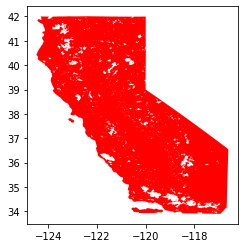

                                              geometry
0    POLYGON ((-121.07098 37.08363, -121.07078 37.0...
1    MULTIPOLYGON (((-121.34320 41.74776, -121.3432...
2    POLYGON ((-116.76104 32.59091, -116.76118 32.5...
3    POLYGON ((-120.61821 38.20575, -120.61812 38.2...
4    MULTIPOLYGON (((-117.53271 34.68821, -117.5327...
..                                                 ...
157  MULTIPOLYGON (((-116.82451 32.77347, -116.8245...
158  MULTIPOLYGON (((-116.57845 32.60993, -116.5784...
159  MULTIPOLYGON (((-117.74203 33.77425, -117.7420...
160  MULTIPOLYGON (((-116.33643 32.65540, -116.3383...
161  MULTIPOLYGON (((-115.33583 33.05028, -115.3358...

[162 rows x 1 columns]


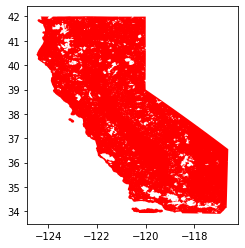

                                              geometry
0    POLYGON ((-116.87449 32.55568, -116.87440 32.5...
1    POLYGON ((-116.77420 32.56410, -116.77421 32.5...
2    POLYGON ((-117.30778 33.75780, -117.30779 33.7...
3    POLYGON ((-116.87363 32.55596, -116.87337 32.5...
4    MULTIPOLYGON (((-117.29796 33.74944, -117.2980...
..                                                 ...
202  MULTIPOLYGON (((-116.82451 32.77347, -116.8245...
203  MULTIPOLYGON (((-116.57845 32.60993, -116.5784...
204  MULTIPOLYGON (((-117.74203 33.77425, -117.7420...
205  MULTIPOLYGON (((-116.33643 32.65540, -116.3383...
206  MULTIPOLYGON (((-115.33583 33.05028, -115.3358...

[207 rows x 1 columns]


TopologyException: found non-noded intersection between LINESTRING (-118.658 34.5399, -118.658 34.5399) and LINESTRING (-118.658 34.5399, -118.658 34.5399) at -118.65841354775637 34.539929588853063


TopologicalError: This operation could not be performed. Reason: unknown

In [44]:
guardados en la carpeta los19anyosAcum

shapeXanyo=[]
acumulado = fuegosXanyo[fuegosXanyo['year']==2000]
keep=["geometry"]
for i in range(20):
    fU=fuegosXanyo[fuegosXanyo['year']==(2000+i)]

    globals()['fuegosU'+ str(2000+i)] = gpd.overlay(fU,acumulado, how='union')
    acumulado = globals()['fuegosU'+ str(2000+i)][keep]
    print(acumulado)
#Esto ha creado und df individual para cada anyo con el nombre: fuegos2000, fuegos2001, etc

    #esto recoge cada uno de los df
    anyoX=globals()['fuegosU' + str(2000+i)]
    
    #la combinacion de los df y el mapa recortado de califorrnia da esto
    zonasXanyoF = gpd.overlay(zonasPosibles,anyoX, how='difference')
    
    zonasXanyoF['year']=2000+i
    
    
    zonasXanyoF.plot(color = 'red')
    plt.show() 
    #shapeXanyo.append(zonasXanyoF)
    
    direccion='fuegos/los19anyosAcum/sinFuegosAcum' + str(2000+i)+ '.shp'                                                  
    zonasXanyoF.to_file(direccion)
    



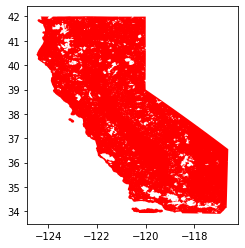

In [7]:
acumulado = gpd.read_file("fuegos/los19anyosAcum/sinFuegosAcum2012.shp")
acumulado.plot(color = 'red')
#plt.show() 

1
1.5
2
3


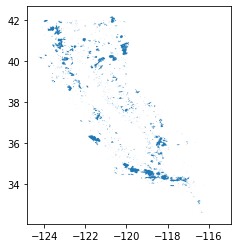

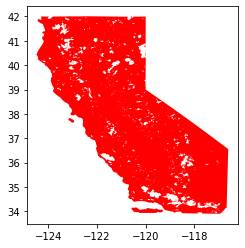

1
1.5
2
3


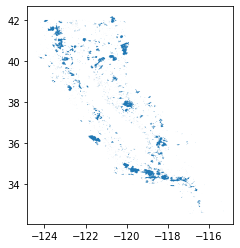

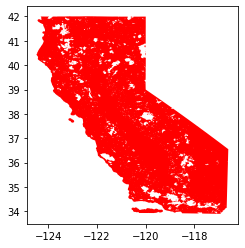

1


AssertionError: Number of manager items must equal union of block items
# manager items: 7, # tot_items: 9

In [17]:
#se habia cortado en 2012

#DEL MAPA DE NO FUEGOS DE 2012 RECUPERO SOLO LOS FUEGOS. 
#acumulado2012 = gpd.read_file("fuegos/los19anyosAcum/sinFuegosAcum2012.shp")
#f_recuperados=gpd.overlay(zonasPosibles,acumulado2012, how='symmetric_difference')
acumulado = f_recuperados
keep=["geometry"]
for i in range(13,20):

    #EXTRAIGO LOS FUEGOS DEL ANYO (1-2013)
    fU=fuegosXanyo[fuegosXanyo['year']==(2000+i)]

    print(1)

    #UNO LOS FUEGOS ANTERIORES Y EL FUEGO ANYADIDO (1-2013)
    globals()['fuegosU'+ str(2000+i)] = gpd.overlay(fU,acumulado, how='union')
    
    #CREO UN SHAPE TEMPORAL CON TODOS LOS FUEGOS HASTA EL MOMENTO
    direccionT='fuegos/los19anyosAcum/FuegosAcumTemp' + str(2000+i)+ '.shp'    
    
    globals()['fuegosU'+ str(2000+i)].to_file(direccionT)
    print(1.5)    
    #RECUPERO EL CLIP CON TODOS LOS FUEGOS QUE ACABO DE CREAR
    acumulado = gpd.read_file(direccionT)
    acumulado.plot()
    #plt.show() 
    
#Esto ha creado und df individual para cada anyo con el nombre: fuegos2000, fuegos2001, etc

    #esto recoge cada uno de los df
    #anyoX=globals()['fuegosU' + str(2000+i)]
    
    #RESTO LOS FUEGOS AL CLIP DE ZONAS POSIBLES (CON DATOS Y EN CALIFORNIA)

    print(2)
    #la combinacion de los df y el mapa recortado de califorrnia da esto
    zonasXanyoF = gpd.overlay(zonasPosibles,acumulado, how='difference')
    zonasXanyoF['year']=2000+i
    
    print(3)    
    zonasXanyoF.plot(color = 'red')
    plt.show() 
    
    #GUARDO EL SHP CON EL MAPA ANUAL DE LO NO QUEMADO 
    direccion='fuegos/los19anyosAcum/sinFuegosAcum' + str(2000+i)+ '.shp' 
    zonasXanyoF.to_file(direccion)
    

In [14]:
import time

start = time.time()
print("hello")
end = time.time()
print(end - start)

hello
0.0004649162292480469


In [10]:
fuegosXanyo=gpd.read_file("fuegos/fuegosXanyo.shp")
fU=fuegosXanyo[fuegosXanyo['year']==(2014)]
fU

,year,geometry
14,2014,"MULTIPOLYGON (((-116.86886 32.57180, -116.8671..."


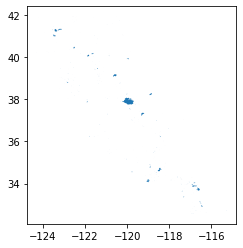

In [11]:
fU.plot()
plt.show()

In [12]:
sinf2013 = gpd.read_file("fuegos/los19anyosAcum/sinFuegosAcum2013.shp")
sinf2013

,NAME,year,geometry
0,California,2013,"MULTIPOLYGON (((-124.13657 41.46446, -124.1379..."


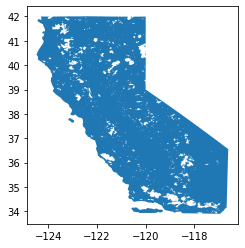

In [5]:
sinf2013.plot()
plt.show()

hello
188.62487888336182


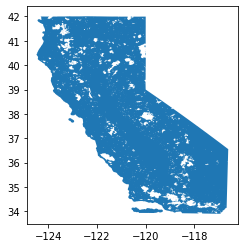

In [15]:
start = time.time()
zonasXanyoF = gpd.overlay(sinf2013,fU, how='difference')

print("hello")
end = time.time()
print(end - start)

zonasXanyoF.plot()
plt.show()


In [20]:
#direccion='fuegos/los19anyosAcum/sinFuegosAcum' + str(2000+i)+ '.shp' 
zonasXanyoF.to_file('fuegos/los19anyosAcum/sinFuegosAcum2014.shp')

In [19]:
zonasXanyoF['year']=2014
zonasXanyoF

,NAME,year,geometry
0,California,2014,"MULTIPOLYGON (((-124.13657 41.46446, -124.1379..."


hello
210.12867784500122


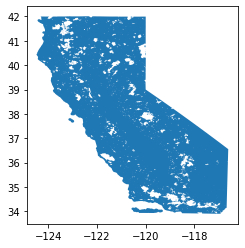

hello
300.60709285736084


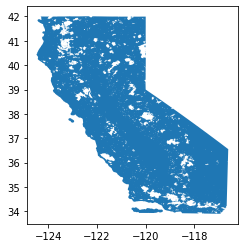

hello
375.27185893058777


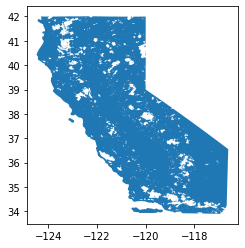

hello
548.0659501552582


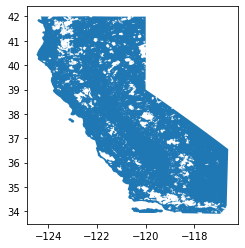

hello
623.5657861232758


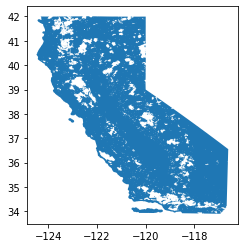

In [21]:
#fuegosXanyo=gpd.read_file("fuegos/fuegosXanyo.shp")
ya guardados
for i in range(15,20):

    fU=fuegosXanyo[fuegosXanyo['year']==(2000+i)]


    direccion1='fuegos/los19anyosAcum/sinFuegosAcum'+ str(2000+i-1) +'.shp'  
    sinf = gpd.read_file(direccion1)


    start = time.time()
    zonasXanyoF = gpd.overlay(sinf,fU, how='difference')

    print("hello")
    end = time.time()
    print(end - start)

    zonasXanyoF.plot()
    plt.show()

    direccion2='fuegos/los19anyosAcum/sinFuegosAcum' + str(2000+i)+ '.shp' 
    zonasXanyoF.to_file(direccion2)
    
#para leerlos
##fuegoshasta2020=gpd.read_file("fuegos/los19anyosAcum/sinFuegosAcum2000.shp")

In [14]:

fuegoshasta2019=gpd.read_file("fuegos/los19anyosAcum/sinFuegosAcum2019.shp")
fuegoshasta2019


,NAME,year,geometry
0,California,2014,"MULTIPOLYGON (((-124.13657 41.46446, -124.1379..."


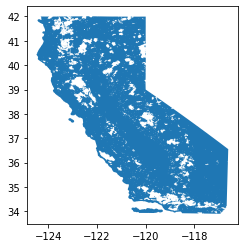

In [15]:
fuegoshasta2019.plot()
plt.show()

In [ ]:
# 4. A partir de aqui, se generaran unos 500 puntos random por cada anyo suponiendo que la mitad son buenos

In [ ]:


fuegosAcumuladosGDF = mydataframe.append(new_row, ignore_index=True)

# AUNQUE CADA MATRIZ DE CADA PUNTO DE IGNICION TENDRA SU EQUIVALENTE EN NO FUEGO, CON LAS CONDICIONES CLIMATOLOGICAS     SERIA MEJOR HACER GRUPOS POR ANYOS QUE SE VAYAN ANADIENDO AL MAPA GENERAL, PARA NO LIMITAR LAS POSIBLES AREAS DE INCENDIO QUE SE INCENDIARAN EN EL FUTURO.

In [17]:
from geopandas import sjoin

In [18]:

#totalNecesario se ha de probar, marca un objetivo. 
def generaterandomPointGDF(boundary,numberofpoints=1200):
    
    x0,x1,y0,y1=boundary.bounds.minx[0],boundary.bounds.maxx[0],boundary.bounds.miny[0],boundary.bounds.maxy[0]

    listaDepuntosposibles=[]

    for x in range(numberofpoints):
        x = np.random.uniform(x0,x1)
        y = np.random.uniform(y0,y1)
        z=x,y
        listaDepuntosposibles.append(z)

    listaDepuntosposibles
    xs=[]
    ys=[]
    for x in range(len(listaDepuntosposibles)):
        xs.append(listaDepuntosposibles[x][0])
        ys.append(listaDepuntosposibles[x][1])

    lista= list(range(numberofpoints))
    puntDf = pd.DataFrame(lista,columns = ['id'])
    puntDf['x']=xs
    puntDf['y']=ys

    punGDF = gpd.GeoDataFrame(puntDf, geometry=gpd.points_from_xy(puntDf.x, puntDf.y))
    punGDF.crs={'init': 'epsg:4326'}
    #punGDF.head()

    pointInPolys = sjoin(punGDF, boundary, how='left')
    
    #p1.within(poly)
    
    listadentro=pointInPolys[pointInPolys['NAME'].notnull()]

    mantener=['year','x','y','geometry']
    listadentro=listadentro[mantener]
    listadentro.reset_index(inplace=False)    
    

    return listadentro 

In [19]:
todosLosRandomXanyos=[]
for i in range(20):
    direccion1='fuegos/los19anyosAcum/sinFuegosAcum'+ str(2000+i) +'.shp'  
    a=gpd.read_file(direccion1)
    listadentro=generaterandomPointGDF(a)


    anyo=len(listadentro)*[(2000+i)]
    listadentro['year']=anyo

    todosLosRandomXanyos.append(listadentro)
    
todosLosRandomXanyos[0]

,year,x,y,geometry
2,2000,-117.930274,37.127210,POINT (-117.93027 37.12721)
5,2000,-120.322840,39.924549,POINT (-120.32284 39.92455)
7,2000,-119.942563,34.559472,POINT (-119.94256 34.55947)
9,2000,-122.007249,40.066326,POINT (-122.00725 40.06633)
10,2000,-116.762114,34.579604,POINT (-116.76211 34.57960)
...,...,...,...,...
1190,2000,-120.658327,37.736657,POINT (-120.65833 37.73666)
1191,2000,-123.047542,38.791830,POINT (-123.04754 38.79183)
1192,2000,-122.453774,37.811639,POINT (-122.45377 37.81164)
1193,2000,-118.484239,37.617245,POINT (-118.48424 37.61725)


In [79]:
todosLosRandomXanyos[-1]

,year,x,y,geometry
0,2019,-120.820945,38.928423,POINT (-120.82094 38.92842)
2,2019,-120.151935,38.771539,POINT (-120.15193 38.77154)
3,2019,-118.911349,35.939671,POINT (-118.91135 35.93967)
5,2019,-119.425439,36.156193,POINT (-119.42544 36.15619)
6,2019,-117.845532,36.729645,POINT (-117.84553 36.72964)
...,...,...,...,...
1185,2019,-117.016656,36.207395,POINT (-117.01666 36.20739)
1190,2019,-119.764779,34.904165,POINT (-119.76478 34.90416)
1191,2019,-119.406929,37.603989,POINT (-119.40693 37.60399)
1197,2019,-120.492774,37.356921,POINT (-120.49277 37.35692)


In [33]:
direccion=('fuegosOrdenadoslimpioWGS84.csv')
dfYOSEMITE_TOTAL = pd.read_csv(direccion, index_col=0)
    
dfYOSEMITE_TOTAL

,GIS_ACRES,noFuegoSLo,noFuegoSLa,geometry,geometrySHP,long_1,long_2,lat_1,lat_2,longitud,latitud
ALARM_DATE,,,,,,,,,,,
2017-12-22,0.001357,-118.288720,36.792561,POINT (-117.6011306680896 33.58980837067615),"POLYGON ((222744.4188000001 -488836.9945, 2227...",-117.601151,-117.601104,33.589795,33.589817,-117.601131,33.589808
2018-07-15,0.001515,-119.054395,36.174709,POINT (-119.2443661690683 34.19851017905983),POLYGON ((69633.66090000048 -423866.9232000001...,-119.244383,-119.244350,34.198499,34.198521,-119.244366,34.198510
2011-09-11,0.001532,-118.911648,36.422262,POINT (-122.9741337274973 38.0803671197143),POLYGON ((-260502.5298999995 11202.54839999974...,-122.974149,-122.974118,38.080354,38.080380,-122.974134,38.080367
2018-01-29,0.001796,-117.262474,36.517322,POINT (-119.3074715681792 34.27707558933125),POLYGON ((63754.62999999896 -415194.2116999999...,-119.307490,-119.307455,34.277062,34.277088,-119.307472,34.277076
2011-08-03,0.002038,-123.524813,39.583718,POINT (-122.4736007666045 37.83340188500182),POLYGON ((-217388.3140999991 -17501.8123000003...,-122.473619,-122.473583,37.833387,37.833417,-122.473601,37.833402
...,...,...,...,...,...,...,...,...,...,...,...
2003-10-25,270686.000000,-115.588488,33.123872,POINT (-116.7655051887372 32.94046743664012),MULTIPOLYGON (((297580.2347999997 -571822.4940...,-117.173632,-116.439200,32.791108,33.132511,-116.765505,32.940467
2017-12-04,281790.875000,-120.663896,36.290824,POINT (-119.2867748778681 34.45030446985317),MULTIPOLYGON (((34867.38589999825 -396856.4573...,-119.682416,-118.922694,34.281967,34.633832,-119.286775,34.450304
2012-08-12,315511.500000,-120.047455,36.820850,POINT (-120.0921399090601 40.61335796016819),"POLYGON ((7076.719399999827 322986.4608999994,...",-120.305703,-119.872660,40.281403,40.925965,-120.092140,40.613358


,year,NumeroFueg,geometry
0,2000,175,"MULTIPOLYGON (((-116.67393 32.62110, -116.6735..."
1,2001,205,"MULTIPOLYGON (((-116.58121 32.61224, -116.5811..."
2,2002,244,"MULTIPOLYGON (((-116.53615 32.58709, -116.5362..."
3,2003,340,"MULTIPOLYGON (((-123.62063 39.14653, -123.6206..."
4,2004,274,"MULTIPOLYGON (((-116.88373 32.55503, -116.8840..."
5,2005,306,"MULTIPOLYGON (((-116.92656 32.55172, -116.9265..."
6,2006,316,"MULTIPOLYGON (((-116.86819 32.56156, -116.8682..."
7,2007,346,"MULTIPOLYGON (((-116.09287 32.61946, -116.0931..."
8,2008,431,"MULTIPOLYGON (((-116.81815 32.57059, -116.8178..."
9,2009,254,"MULTIPOLYGON (((-116.80141 32.63097, -116.8014..."
